# 明日方舟“地生五金”卡池解析
by 我叫胡喵喵@NGA    
2019 Jan 13

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import trange

old_6_num = 17 #old 6-star
player_num = 100000

In [2]:
class Player(object):
    def __init__(self, stop_cond):
        self.gacha_count = 0
        self.no_6_count = 0
        self.have_nian = False
        self.have_aak = False
        self.stop_cond= stop_cond #stop condition, string or 
    
    def restart(self):
        self.gacha_count = 0
        self.no_6_count = 0
        self.have_nian = False
        self.have_aak = False
        
    def gacha(self, gacha_machine):
        self.gacha_count += 1
        card = gacha_machine.gacha(self)
        if card == 'nian':
            self.have_nian = True
            self.no_6_count = 0
        elif card == 'aak':
            self.have_aak = True
            self.no_6_count = 0
        elif card == 'other_6':
            self.no_6_count = 0
        else:
            self.no_6_count += 1
        return card
        
    def stop(self): 
        if type(self.stop_cond) == str:
            if self.stop_cond == 'new_2':
                return (self.have_nian and self.have_aak)
            elif self.stop_cond == 'new_any_1':
                return (self.have_nian or self.have_aak)
            elif self.stop_cond == 'new_nian':
                return self.have_nian
            elif self.stop_cond == 'new_aak':
                return self.have_aak
            else:
                raise ValueError("Undefined stop condition: {}".format(stop_cond))
        elif type(self.stop_cond) == int:
            return self.gacha_count >= self.stop_cond
        else:
            raise ValueError("Undefined stop condition: {}".format(stop_cond))

In [3]:
class Gacha_machine(object):
    def __init__(self, up_type):
        if up_type == 'double':
            self.nian_in_6 = 0.35
            self.aak_in_6 = 0.35
        elif up_type == 'nian':
            self.nian_in_6 = 0.5
            self.aak_in_6 = 0.5/(old_6_num+1)
        elif up_type == 'aak':
            self.aak_in_6 = 0.5
            self.nian_in_6 = 0.5/(old_6_num+1)
        else:
            raise ValueError("Undefined up type: {}".format(up_type))
        np.random.seed(20200116) # to fix random state, make it reproducable
            
    def _full_portion(self, player):
        # determin the portion of 6 stars
        no_6_count = player.no_6_count
        if no_6_count < 51:
            p_6 = 0.02
        elif no_6_count < 100:
            p_6 = 0.02 + 0.02*(no_6_count-50)
        else:
            raise RuntimeError("Why no_6_count can be {}?".format(no_6_count))
        # determine the portion of 4 conditions
        p_no_6 = 1 - p_6
        p_nian = p_6 * self.nian_in_6
        p_aak = p_6 * self.aak_in_6
        p_other_6 = p_6 * (1-self.nian_in_6-self.aak_in_6)
        return p_no_6, p_nian, p_aak, p_other_6
        
    def gacha(self, player):
        p_list = self._full_portion(player)
        #print("probabilities: no_6, nian, aak, other_6 \n" + 
        #    "{:.4f}, {:.4f}, {:.4f}, {:.4f}".format(*p_list))
        stumps = [sum(p_list[:a+1]) for a in range(len(p_list))]
        assert abs(stumps[-1]-1) < 1e-10, \
        "Why all probs ({}) don't sum to 1?".format(p_list)
        rand_num = np.random.rand(1)
        if rand_num < stumps[0]:
            return 'no_6'
        elif rand_num < stumps[1]:
            return 'nian'
        elif rand_num < stumps[2]:
            return 'aak'
        else:
            return 'other_6'

In [4]:
gacha_double = Gacha_machine('double')
gacha_nian = Gacha_machine('nian')
gacha_aak = Gacha_machine('aak')

## 抽数有限型
兼复现 sagasdgsags@NGA 数据贴 https://ngabbs.com/read.php?tid=19982718 部分结论


### 抽取“地生五金”池

In [5]:
gacha_double_portion_list = []
print("地生五金池")
print("      年阿均无  有阿无年  有年无阿  年阿均有  的概率分别为：")
for N in (25,50,75,100,150,200,300):
    player = Player(N)
    nian_aak_list = []
    for a in trange(player_num, desc='players', leave=False):
        player.restart()
        while not player.stop():
            player.gacha(gacha_double)
        nian_aak_list.append((player.have_nian, player.have_aak))

    four_conditions_list = [((not na[0]) and (not na[1]), (na[0] and (not na[1])), (not na[0]) and na[1], na[0] and na[1]) 
                            for na in nian_aak_list]
    neither_arr = np.array([four[0] for four in four_conditions_list]).astype(np.float)
    nian_arr = np.array([four[1] for four in four_conditions_list]).astype(np.float)
    aak_arr = np.array([four[2] for four in four_conditions_list]).astype(np.float)
    both_arr = np.array([four[3] for four in four_conditions_list]).astype(np.float)

    neither_portion = sum(neither_arr)/len(neither_arr)
    aak_portion = sum(aak_arr)/len(aak_arr)
    nian_portion = sum(nian_arr)/len(nian_arr)
    both_portion = sum(both_arr)/len(both_arr)
    gacha_double_portion_list.append([neither_portion, aak_portion, nian_portion, both_portion])

    print("{:3d}抽   {:.2f}%   {:.2f}%   {:.2f}%    {:.2f}% ".format(
        N, neither_portion*100, aak_portion*100, nian_portion*100, both_portion*100))

地生五金池
      年阿均无  有阿无年  有年无阿  年阿均有  的概率分别为：


 25抽   70.34%   13.56%   13.64%    2.46% 


 50抽   49.50%   20.66%   21.06%    8.78% 


 75抽   16.45%   31.22%   31.39%    20.95% 


100抽   9.35%   27.60%   27.93%    35.12% 


150抽   2.05%   18.34%   18.70%    60.91% 


200抽   0.44%   11.04%   11.13%    77.39% 


300抽   0.02%   3.63%   3.68%    92.67% 


## 抽取“50%单up日替池” (优先抽"年")

In [6]:
gacha_alter_portion_list = []
print("日替池")
print("      年阿均无  有阿无年  有年无阿  年阿均有  的概率分别为：")
for N in (25,50,75,100,150,200,300):
    player = Player(N)
    nian_aak_list = []
    for a in trange(player_num, desc='players', leave=False):
        player.restart()
        while (not player.have_nian) and (not player.stop()):
            player.gacha(gacha_nian)
        while (not player.have_aak) and (not player.stop()):
            player.gacha(gacha_aak)
        nian_aak_list.append((player.have_nian, player.have_aak))

    four_conditions_list = [((not na[0]) and (not na[1]), (na[0] and (not na[1])), (not na[0]) and na[1], na[0] and na[1]) 
                            for na in nian_aak_list]
    neither_arr = np.array([four[0] for four in four_conditions_list]).astype(np.float)
    nian_arr = np.array([four[1] for four in four_conditions_list]).astype(np.float)
    aak_arr = np.array([four[2] for four in four_conditions_list]).astype(np.float)
    both_arr = np.array([four[3] for four in four_conditions_list]).astype(np.float)

    neither_portion = sum(neither_arr)/len(neither_arr)
    nian_portion = sum(nian_arr)/len(nian_arr)
    aak_portion = sum(aak_arr)/len(aak_arr)
    both_portion = sum(both_arr)/len(both_arr)
    gacha_alter_portion_list.append([neither_portion, aak_portion, nian_portion, both_portion])

    print("{:3d}抽   {:.2f}%   {:.2f}%   {:.2f}%    {:.2f}% ".format(
        N, neither_portion*100, aak_portion*100, nian_portion*100, both_portion*100))

日替池
      年阿均无  有阿无年  有年无阿  年阿均有  的概率分别为：


 25抽   76.72%   1.09%   19.46%    2.73% 


 50抽   58.89%   1.67%   30.23%    9.22% 


 75抽   29.78%   2.56%   44.96%    22.71% 


100抽   20.31%   2.19%   39.77%    37.73% 


150抽   7.47%   1.42%   25.63%    65.48% 


200抽   2.89%   0.77%   14.27%    82.07% 


300抽   0.43%   0.18%   3.43%    95.96% 


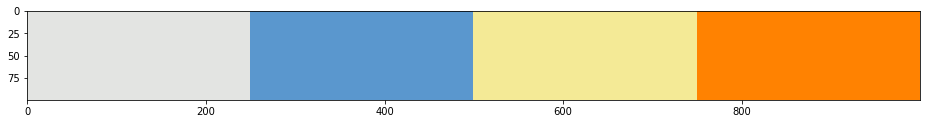

In [25]:
gray = (227,228,226)
blue = (90,151,206)
gold = (244,234,150)
orange = (255,130,1)

width = 1000
height = width//10

In [28]:
for p_list, gacha_count in zip(gacha_double_portion_list, (25,50,75,100,150,200,300)):
    stumps = [sum(p_list[:a+1]) for a in range(len(p_list))]
    stumps = np.round(1000*np.array([0]+stumps)).astype(np.int)
    test_board = np.zeros((height,width,3), dtype=np.uint8)
    for lx,rx,color in zip(stumps[:-1],stumps[1:],[gray,blue,gold,orange]):
        for ch,v in enumerate(color):
            test_board[:,lx:rx,ch] = v
    cv2.imwrite("double_{}draw_{:.2f}-{:.2f}-{:.2f}-{:.2f}.png".format(
                    gacha_count, neither_portion*100, aak_portion*100, nian_portion*100, both_portion*100),
                cv2.cvtColor(test_board, cv2.COLOR_RGB2BGR))

In [29]:
for p_list, gacha_count in zip(gacha_alter_portion_list, (25,50,75,100,150,200,300)):
    stumps = [sum(p_list[:a+1]) for a in range(len(p_list))]
    stumps = np.round(1000*np.array([0]+stumps)).astype(np.int)
    test_board = np.zeros((height,width,3), dtype=np.uint8)
    for lx,rx,color in zip(stumps[:-1],stumps[1:],[gray,blue,gold,orange]):
        for ch,v in enumerate(color):
            test_board[:,lx:rx,ch] = v
    cv2.imwrite("alter_{}draw_{:.2f}-{:.2f}-{:.2f}-{:.2f}.png".format(
                    gacha_count, neither_portion*100, aak_portion*100, nian_portion*100, both_portion*100),
                cv2.cvtColor(test_board, cv2.COLOR_RGB2BGR))

## 不成不休型

### 抽取"地生五金"池

In [5]:
player_num = 100000
gacha_double_nian_occur_arr = np.zeros(player_num, dtype=np.int)
gacha_double_aak_occur_arr = np.zeros(player_num, dtype=np.int)
player = Player('new_2')
for a in trange(player_num, desc='players', leave=False):
    player.restart()
    while not player.stop():
        card = player.gacha(gacha_double)
        if card=='nian' and (gacha_double_nian_occur_arr[a]==0):
            gacha_double_nian_occur_arr[a] = player.gacha_count
        if card=='aak' and (gacha_double_aak_occur_arr[a]==0):
            gacha_double_aak_occur_arr[a] = player.gacha_count
            
gacha_double_either_occur_arr = \
    np.array([min(a,b) for a,b in 
              zip(gacha_double_nian_occur_arr, gacha_double_aak_occur_arr)])
gacha_double_both_occur_arr = \
    np.array([max(a,b) for a,b in 
              zip(gacha_double_nian_occur_arr, gacha_double_aak_occur_arr)])
gacha_double_for_nian_get_aak_too_arr = \
    np.array([a>b for a,b in 
              zip(gacha_double_nian_occur_arr, gacha_double_aak_occur_arr)]).astype(np.int)
for_nian_get_aak_rate = np.sum(gacha_double_for_nian_get_aak_too_arr)/player_num
print("目标是抽年，但抽年过程中也抽到阿的概率为：{}。(理论概率0.5)".format(for_nian_get_aak_rate))

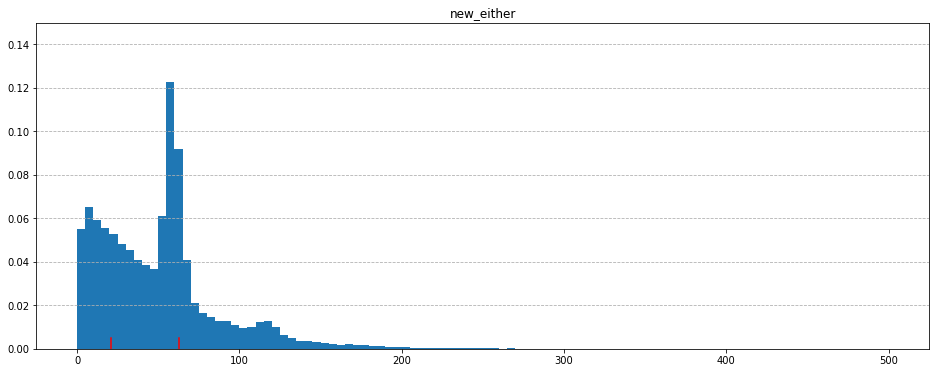

平均抽数：49.91435，中位数：50.0，众数：57，欧线：21.0，非线：63.0


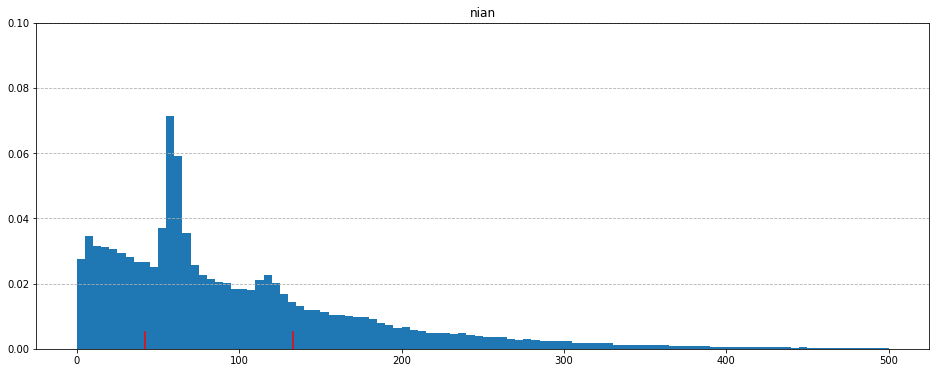

平均抽数：99.55431，中位数：71.0，众数：57，欧线：42.0，非线：133.0


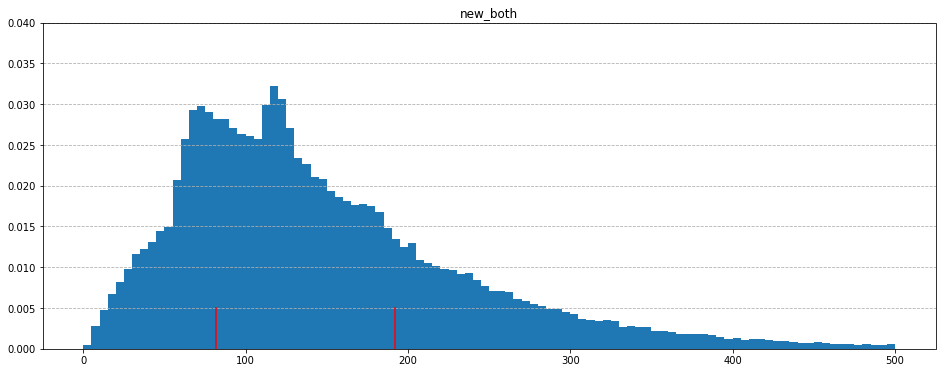

平均抽数：149.42269，中位数：127.0，众数：119，欧线：82.0，非线：192.0


In [15]:
for S, title, y_max in zip([gacha_double_either_occur_arr, gacha_double_nian_occur_arr, gacha_double_both_occur_arr],
                           ['new_either','nian','new_both'],
                           [0.15, 0.10, 0.040]):
    mean = np.mean(S)
    median = np.median(S)
    mode = np.argmax(np.bincount(S))
    eu_line = np.percentile(S,25)
    af_line = np.percentile(S,75)
    
    plt.figure(figsize=(16,6))
    plt.hist(S, weights=np.ones_like(S) / len(S),
             range=(0,500), bins=100)
    plt.ylim(0, y_max)
    plt.grid(axis='y',linestyle='--')
    plt.plot([eu_line, eu_line], [0, 0.005], color='r', linestyle='-')
    plt.plot([af_line, af_line], [0, 0.005], color='r', linestyle='-')
    plt.title(title)
    plt.savefig('double-'+title+'.png')
    plt.show()

    print("平均抽数：{}，中位数：{}，众数：{}，欧线：{}，非线：{}".format(
        mean, median, mode, eu_line, af_line))

### 抽取日替池

In [6]:
player_num = 100000
gacha_alter_nian_occur_arr = np.zeros(player_num, dtype=np.int)
gacha_alter_aak_occur_arr = np.zeros(player_num, dtype=np.int)
player = Player('new_2')
for a in trange(player_num, desc='players', leave=False):
    player.restart()
    while not player.have_nian:
        card = player.gacha(gacha_nian)
        if card=='nian' and (gacha_alter_nian_occur_arr[a]==0):
            gacha_alter_nian_occur_arr[a] = player.gacha_count
        if card=='aak' and (gacha_alter_aak_occur_arr[a]==0): #需注意，年池中也会出阿
            gacha_alter_aak_occur_arr[a] = player.gacha_count
    while not player.have_aak:
        card = player.gacha(gacha_aak)
        if card=='aak' and (gacha_alter_aak_occur_arr[a]==0):
            gacha_alter_aak_occur_arr[a] = player.gacha_count
        # 已经有年了，阿池中出年不必处理

gacha_alter_either_occur_arr = \
    np.array([min(a,b) for a,b in 
              zip(gacha_alter_nian_occur_arr, gacha_alter_aak_occur_arr)])
gacha_alter_both_occur_arr = \
    np.array([max(a,b) for a,b in 
              zip(gacha_alter_nian_occur_arr, gacha_alter_aak_occur_arr)])

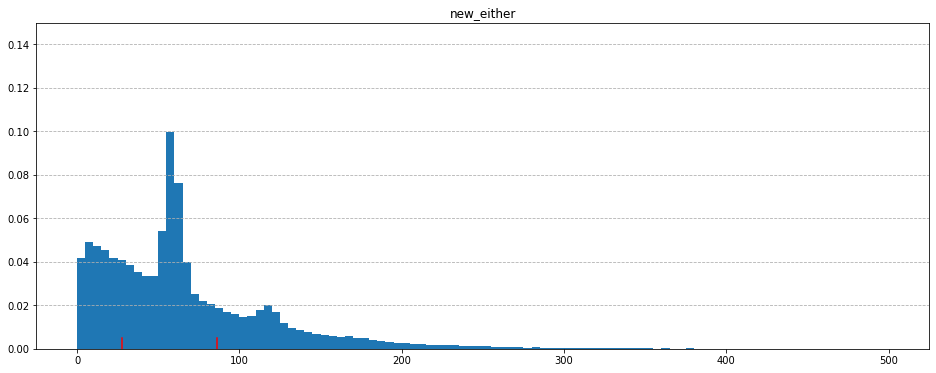

平均抽数：65.88451，中位数：57.0，众数：57，欧线：28.0，非线：86.0


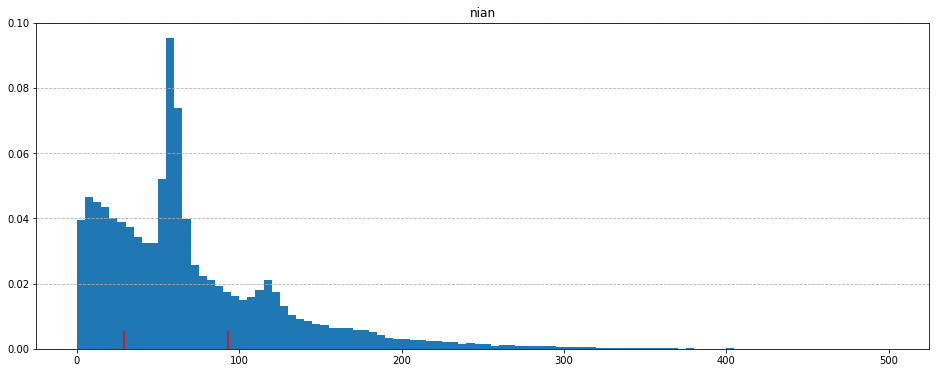

平均抽数：69.61995，中位数：58.0，众数：57，欧线：29.0，非线：93.0


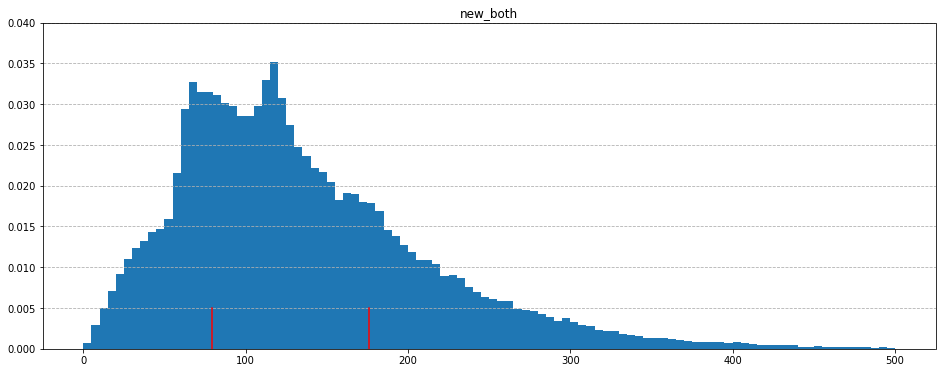

平均抽数：135.74711，中位数：120.0，众数：115，欧线：79.0，非线：176.0


In [16]:
for S, title, y_max in zip([gacha_alter_either_occur_arr, gacha_alter_nian_occur_arr, gacha_alter_both_occur_arr],
                           ['new_either','nian','new_both'],
                           [0.15, 0.10, 0.040]):
    mean = np.mean(S)
    median = np.median(S)
    mode = np.argmax(np.bincount(S))
    eu_line = np.percentile(S,25)
    af_line = np.percentile(S,75)
    
    plt.figure(figsize=(16,6))
    plt.hist(S, weights=np.ones_like(S)/len(S),
             range=(0,500), bins=100)
    plt.ylim(0, y_max)
    plt.grid(axis='y',linestyle='--')
    plt.plot([eu_line, eu_line], [0, 0.005], color='r', linestyle='-')
    plt.plot([af_line, af_line], [0, 0.005], color='r', linestyle='-')
    plt.title(title)
    plt.savefig('alter-'+title+'.png')
    plt.show()

    print("平均抽数：{}，中位数：{}，众数：{}，欧线：{}，非线：{}".format(
        mean, median, mode, eu_line, af_line))

## 应坛友提问，双满潜所需抽数

### 抽取“地生五金池”

In [13]:
player_num = 100000
double_full_arr = np.zeros(player_num, dtype=np.int)
player = Player('new_2')
for a in trange(player_num, desc='players', leave=False):
    player.restart()
    nian_count = 0
    aak_count = 0
    while (nian_count<6 or aak_count<6):
        card = player.gacha(gacha_double)
        if card=='nian':
            nian_count += 1
        if card=='aak':
            aak_count += 1
    double_full_arr[a] = player.gacha_count

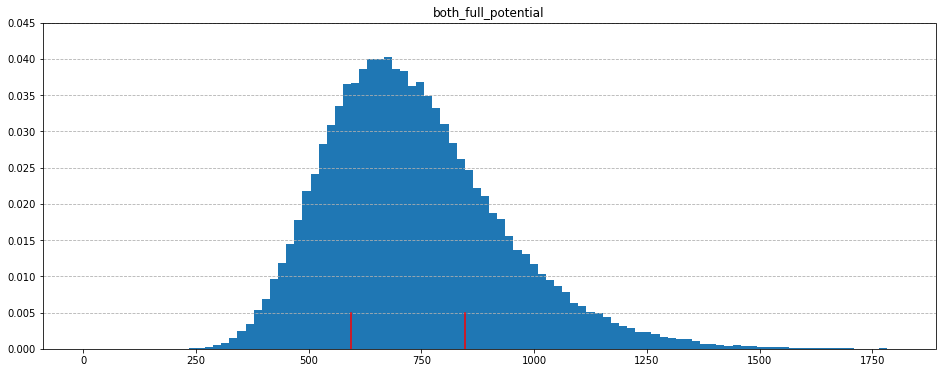

平均抽数：733.73732，中位数：708.0，众数：642，欧线：593.0，非线：846.0


In [19]:
S = double_full_arr
title = 'both_full_potential'
y_max = 0.045
n_max = 1800

mean = np.mean(S)
median = np.median(S)
mode = np.argmax(np.bincount(S))
eu_line = np.percentile(S,25)
af_line = np.percentile(S,75)

plt.figure(figsize=(16,6))
plt.hist(S, weights=np.ones_like(S)/len(S),
         range=(0,n_max), bins=100)
plt.ylim(0, y_max)
plt.grid(axis='y',linestyle='--')
plt.plot([eu_line, eu_line], [0, 0.005], color='r', linestyle='-')
plt.plot([af_line, af_line], [0, 0.005], color='r', linestyle='-')
plt.title(title)
plt.savefig('double-'+title+'.png')
plt.show()

print("平均抽数：{}，中位数：{}，众数：{}，欧线：{}，非线：{}".format(
    mean, median, mode, eu_line, af_line))

### 抽取日替池(仅抽年，不考虑阿)

In [20]:
player_num = 100000
single_full_arr = np.zeros(player_num, dtype=np.int)
player = Player('new_2')
for a in trange(player_num, desc='players', leave=False):
    player.restart()
    nian_count = 0
    aak_count = 0
    while (nian_count<6):
        card = player.gacha(gacha_nian)
        if card=='nian':
            nian_count += 1
        if card=='aak':
            aak_count += 1
    single_full_arr[a] = player.gacha_count

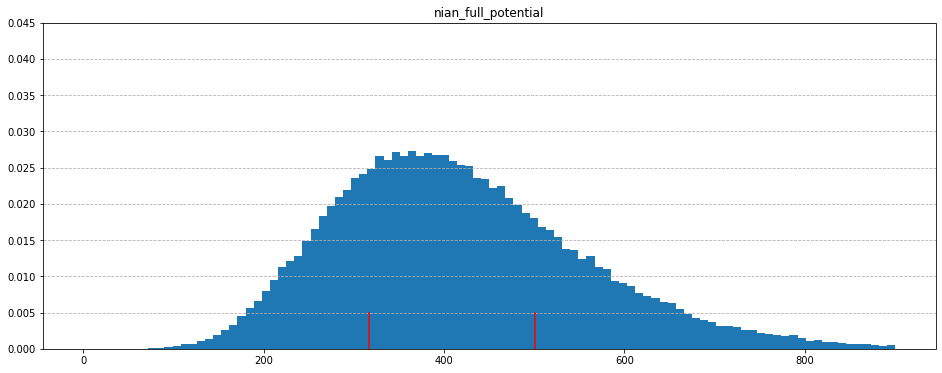

平均抽数：418.3736，中位数：401.0，众数：348，欧线：317.0，非线：501.0


In [21]:
S = single_full_arr
title = 'nian_full_potential'
y_max = 0.045
n_max = 900

mean = np.mean(S)
median = np.median(S)
mode = np.argmax(np.bincount(S))
eu_line = np.percentile(S,25)
af_line = np.percentile(S,75)

plt.figure(figsize=(16,6))
plt.hist(S, weights=np.ones_like(S)/len(S),
         range=(0,n_max), bins=100)
plt.ylim(0, y_max)
plt.grid(axis='y',linestyle='--')
plt.plot([eu_line, eu_line], [0, 0.005], color='r', linestyle='-')
plt.plot([af_line, af_line], [0, 0.005], color='r', linestyle='-')
plt.title(title)
plt.savefig('aalter-'+title+'.png')
plt.show()

print("平均抽数：{}，中位数：{}，众数：{}，欧线：{}，非线：{}".format(
    mean, median, mode, eu_line, af_line))